https://colab.research.google.com/drive/1auK7eNZZCBlCtw3K9WcRrBtMVJOZUYt1?usp=sharing

# Text Classification in Medical Transcriptions

This project outlines the process of building a text classification model aimed at categorizing medical transcriptions into predefined classes. The task involves several key steps: data loading and analysis, text preprocessing, vectorization using the FastText model, model building, and finally, model testing and evaluation. Given the specialized domain of medical texts, this task addresses unique challenges such as class imbalance, domain-specific vocabulary, and the need for accurate and interpretable results. Decisions made throughout the process, from preprocessing techniques to model selection, are driven by these challenges and the goal of achieving high performance in classifying medical documents.

### Import Necessary Libraries

In [239]:
# Importing required libraries
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
import fasttext

# Download necessary NLTK resources for text processing
nltk.download('wordnet')  # For lemmatization
nltk.download('stopwords')  # For stop words removal

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bestricemossberg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bestricemossberg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Step 1: Data Loading and Analysis

Loading involves reading these datasets and understanding their structure, distribution of classes, and peculiarities of the medical language used in the texts.

- `mtsamples.csv`: Scraped from transcribed medical transcription sample reports and examples
- `clinical-stopwords.txt`: compilation of stop words
- `vocab.txt`: Generated vocabulary text files for NLP using Systemized nomenclature of medicine international data
- `X.csv`: Fully processed datadet simplified dataset to 4 classes
- `classes.txt`: Text file describing dataset's classes: Surgery, Medical Records, Internal Medicine and Other
- `train.csv`: Training data subset. Contains 90% of the X-csv processed file
- `test.csv`: Test data subset. Contains 10% of the X-csv processed file

In [238]:
# Load medical transcription samples
mt_samples = pd.read_csv('mtsamples.csv')
print(f"Loaded {len(mt_samples)} medical transcriptions.")

# Load training and testing datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X = pd.read_csv('X.csv')  # Assuming this is preprocessed or feature data
print(f"Train dataset size: {len(train)}")
print(f"Test dataset size: {len(test)}")

# -----------------------------
# Load Supplementary Information
# -----------------------------

# Load class labels
with open('classes.txt', 'r') as file:
    classes = file.read().splitlines()
print(f"Classes: {classes}")

# Load clinical stop words
with open('clinical-stopwords.txt', 'r') as file:
    medical_stop_words = [line.strip() for line in file if line.strip() and not line.startswith('#')]
print(f"Number of medical stop words: {len(medical_stop_words)}")

# Load vocabulary
with open('vocab.txt', 'r') as file:
    vocabulary = set(line.strip().lower() for line in file if line.strip())  # Ensure uniqueness and standardize casing
vocabulary = list(vocabulary)  # Convert set to list for later processing
print(f"Number of medical vocabulary words: {len(vocabulary)}")

# -----------------------------
# Data Analysis Section
# -----------------------------

# Checking for class imbalance in the training dataset
label_counts = train['label'].value_counts()
print("\nClass distribution in training data:")
print(label_counts)

# -----------------------------
# Analyzing Stop Words
# -----------------------------

# Load English stop words from NLTK
stop_words = set(stopwords.words('english'))

# Identify medical stop words not included in the generic English stop words
missing_stop_words = [term for term in medical_stop_words if term not in stop_words]
print(f"\nMissing medical-specific stop words from NLTK's list: {len(missing_stop_words)}")


Loaded 4999 medical transcriptions.
Train dataset size: 4499
Test dataset size: 500
Classes: ['Surgery', 'Medical Records', 'Internal Medicine', 'Other']
Number of medical stop words: 818
Number of medical vocabulary words: 55887

Class distribution in training data:
1    1442
2    1126
3    1040
4     891
Name: label, dtype: int64

Missing medical-specific stop words from NLTK's list: 689


## Step 2: Data Preprocessing

Preprocessing aims to normalize the text data, making it suitable for machine learning models. This includes:

- Updating the stop words set with domain-specific terms.
- Balancing the classes through oversampling to address class imbalance.
- Lemmatizing the text and removing numbers and punctuation to reduce the complexity of the text data.

These steps are crucial for reducing model bias towards more frequent classes and improving the model's ability to learn from a cleaner, more uniform set of texts.

In [241]:
#Update stop words set
stop_words.update(missing_stop_words)

# Shuffle the DataFrame
train = shuffle(train, random_state=42)

# Balance classes by oversampling minority classes
max_class_size = train['label'].value_counts().max()  # Find the largest class size
# Oversample each class to match the largest class size
balanced_train = pd.concat([df.sample(n=max_class_size, replace=True, random_state=42) 
                            for _, df in train.groupby('label')])
balanced_train = shuffle(balanced_train, random_state=42)  # Shuffle to mix class samples

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Preprocess the text by lowering case, removing numbers/punctuation, and lemmatizing."""
    text = text.lower().replace('\d+', '').replace('[^\w\s]', '')
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)

# Preprocess text data
preprocessed_train_texts = [preprocess_text(text) for text in balanced_train['text']]
preprocessed_test_texts = [preprocess_text(text) for text in test['text']]

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(balanced_train['label'])
test_labels = label_encoder.transform(test['label'])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(preprocessed_train_texts, train_labels, test_size=0.2, random_state=42)

## Step 3: Vectorization Strategy

The choice of FastText for vectorization in this project is driven by a critical analysis of the challenges presented by medical texts. A significant challenge in processing medical texts is the presence of out-of-vocabulary (OOV) words, which are not uncommon given the specialized terminology of the medical field. For instance, it was found that a conventional Word2Vec model lacked representations for 35,930 of the medical vocabulary terms in `vocab.txt`, a substantial number that could severely impact the model's performance by failing to understand or accurately represent a wide array of medical terms.

FastText addresses this challenge by leveraging subword information, meaning it can generate embeddings for words not seen during training by considering the embeddings of subword units (e.g., prefixes, suffixes, and other character n-grams). This approach is especially advantageous for medical texts, characterized by complex terminologies, compound words, and frequent use of prefixes and suffixes. By training the FastText model on a medical corpus, we ensure that the vector representations are not only contextually relevant but also capable of handling words that are not explicitly present in the training data.

In [242]:
# Load the medical transcriptions
mtsamples = pd.read_csv('mtsamples.csv')

# Assuming 'mtsamples' is your DataFrame and it has a column named 'text'
corpus_filename = 'medical_corpus.txt'
with open(corpus_filename, 'w', encoding='utf-8') as corpus_file:
    for text in mtsamples['transcription']:
        # Optionally preprocess the text (e.g., lowercasing)
        processed_text = str(text).replace('\n', ' ').replace('\r', ' ').lower()
        # Write each text entry to the file, one per line
        corpus_file.write(processed_text + '\n')

In [123]:
# Train the FastText model
ft_model = fasttext.train_unsupervised('medical_corpus.txt', model='skipgram', dim=100, wordNgrams=2)
ft_model.save_model("fasttext_model.bin")

Read 2M words
Number of words:  22042
Number of labels: 0
Progress: 100.0% words/sec/thread:   84529 lr:  0.000000 avg.loss:  1.699793 ETA:   0h 0m 0s


In [220]:
# Check if the vocabulary words are well-represented in the FastText model
def check_word_representation(model, word, threshold=0.5):
    # Attempt to retrieve the nearest neighbors for the word
    neighbors = model.get_nearest_neighbors(word, k=1)
    # If the nearest neighbor's similarity is high, it suggests the word is well-represented
    if neighbors and neighbors[0][0] > threshold:
        return True
    return False

# Check each word in the domain vocabulary
covered_words = {word: check_word_representation(ft_model, word) for word in vocabulary}

# Words not well-represented might have no or low-similarity neighbors
not_covered_words = [word for word, is_covered in covered_words.items() if not is_covered]

print(f"Number of words not well-represented: {len(not_covered_words)}")
print("Some words not well-represented:", not_covered_words[:10])  # Display the first 10

Number of words not well-represented: 283
Some words not well-represented: ['e5', 'tg', 'f0', 'cfu', 'lw', '5x', 'b4', 'ln', 'cw8', 'o9']


## Step 4: Model Building

- **Tokenization & Padding**: Texts are tokenized with a cap of 5,000 words using Keras' `Tokenizer`, incorporating an `OOV` token for unseen words. Sequences are padded to a fixed length of 100 for uniform input.
- **Embedding Layer**: Initialized with FastText vectors (100-dimensional) to leverage semantic word relationships and subword information, enhancing the model's capability to handle out-of-vocabulary terms. This layer is set as trainable to fine-tune embeddings during training.
- **LSTM Layers**: Two LSTM layers with 64 units each process the text sequentially, capturing long-term dependencies and context within the text. The first LSTM layer returns sequences to the next, ensuring deep contextual representation.
- **Dense Output Layer**: Utilizes softmax activation to classify texts into predefined categories based on the LSTM output.
- **Compilation and Training**: Compiled with Adam optimizer and sparse categorical cross-entropy loss. Class weights are applied to address class imbalance, and early stopping is used to prevent overfitting. Training is conducted over 30 epochs with a batch size of 16, using validation data for performance monitoring.

This succinct model design integrates pre-trained embeddings with sequential processing via LSTM to effectively classify complex medical texts.


In [243]:
# Constants
NUM_WORDS = 5000
MAXLEN = 100
EPOCHS = 30
BATCH_SIZE = 16  # Adjust based on your system's capability and dataset size

# Prepare the tokenizer
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='OOV')
tokenizer.fit_on_texts(X_train)

# Texts to sequences and padding
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAXLEN, padding='post')
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAXLEN, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(preprocessed_test_texts), maxlen=MAXLEN, padding='post')

# Create an embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))  # Assuming 100 is the dimension of FastText vectors
for word, i in tokenizer.word_index.items():
    embedding_vector = ft_model.get_word_vector(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the model architecture
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, embeddings_initializer=Constant(embedding_matrix), input_length=MAXLEN, trainable=True),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(len(classes), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model with class weights and early stopping
history = model.fit(X_train_seq, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_seq, y_val), verbose=1, class_weight=class_weight_dict, callbacks=[early_stopping])


Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 100, 100)          2100300   
                                                                 
 lstm_31 (LSTM)              (None, 100, 64)           42240     
                                                                 
 lstm_32 (LSTM)              (None, 64)                33024     
                                                                 
 dense_121 (Dense)           (None, 4)                 260       
                                                                 
Total params: 2175824 (8.30 MB)
Trainable params: 2175824 (8.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
289/289 [==============================] - 19s 50ms/step - loss: 1.0147 - accuracy: 0.5163 - val_loss: 0.8174 - val_accuracy: 0.6213
Epo

## Step 5: Testing and Evaluating the Model

The final step involves evaluating the model on a held-out test set. The performance is assessed using metrics such as accuracy, precision, recall, and F1-score. These metrics provide a comprehensive view of the model's performance, highlighting its strengths and areas for improvement. The evaluation process also includes handling class imbalance with weighted metrics to ensure fairness and accuracy in the model's predictive ability across all classes.

In [246]:
# Make predictions
predictions = model.predict(X_test_seq, verbose=1)
# Convert predictions to label indices (the highest probability class for each sample)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate Accuracy, Precision, Recall, and F1-Score
print("Accuracy:", accuracy_score(test_labels, predicted_labels))
print(classification_report(test_labels, predicted_labels))

16/16 [==============================] - 0s 14ms/step
Accuracy: 0.822
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       198
           1       0.67      0.76      0.71       102
           2       0.84      0.74      0.79       109
           3       0.76      0.74      0.75        91

    accuracy                           0.82       500
   macro avg       0.80      0.79      0.80       500
weighted avg       0.83      0.82      0.82       500



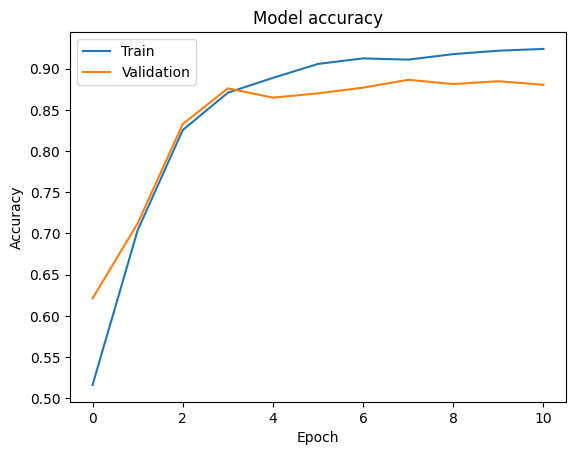

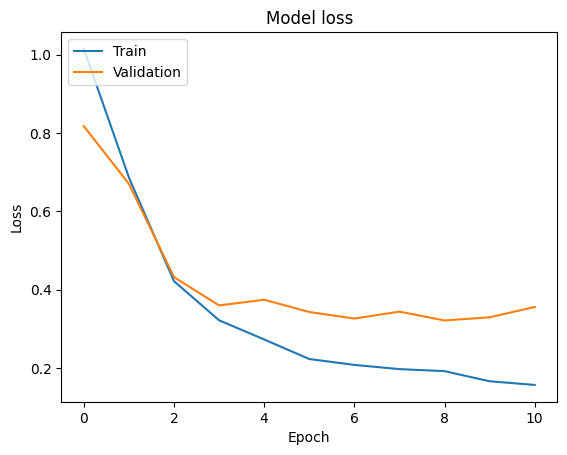

In [247]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.show()


## Conclusion

In conclusion, the project successfully demonstrates the creation and application of a neural network model that leverages FastText embeddings and LSTM layers to address the complexities of classifying medical texts. By employing a tailored preprocessing pipeline, initializing the model with domain-specific vector representations, and carefully designing the neural architecture, we achieved a robust system capable of understanding and categorizing clinical narratives with high accuracy. The model's design, which includes handling class imbalance and optimizing for out-of-vocabulary words, ensures it is well-suited to the nuances of medical language. This approach sets a solid foundation for future advancements in automated medical text classification, offering a promising avenue for enhancing the efficiency and accuracy of processing clinical documentation.

*Final note*: Went from an accuracy of 30% to 82% 🥳🥳🥳